# Import packages

In [2]:
import pandas as pd
import matplotlib.colors as mcol
import matplotlib.cm as cm
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
from mpl_toolkits import mplot3d

usv=pd.read_csv('us_state_vaccinations.csv')
cuc=pd.read_csv('covid_us_county.csv')
uc=pd.read_csv('us_county.csv')
vote=pd.read_csv('voting.csv')
usv_date=usv[usv.date=="2021-11-10"]

# Correlation With COVID-19 Vaccination and Political Orientations

## Merge data

In [3]:
county_mer=pd.merge(cuc,uc,how='left', on='fips')
county_mer2=county_mer.groupby("county_x").agg({"state_x":"min","cases":"max","deaths":"max","population":"mean"})
county_mer2.head(5)

,state_x,cases,deaths,population
county_x,,,,
Abbeville,South Carolina,3879,50,24657.00
Acadia,Louisiana,10543,250,62568.00
Accomack,Virginia,4124,80,32742.00
Ada,Idaho,83260,797,446052.00
Adair,Iowa,4901,80,18450.75


In [4]:
state_mer=county_mer2.groupby("state_x").sum()
state_mer["cases_per_hundred"]=(state_mer["cases"]/state_mer["population"])*100
state_mer["deaths_per_hundred"]=(state_mer["deaths"]/state_mer["population"])*100
state_mer.head(5)

,cases,deaths,population,cases_per_hundred,deaths_per_hundred
state_x,,,,,
Alabama,2652659,61648,5.109719e+06,51.913992,1.206485
Alaska,149031,958,7.498465e+05,19.874868,0.127759
Arizona,1210516,21556,6.939844e+06,17.442987,0.310612
Arkansas,1454495,22611,2.855683e+06,50.933347,0.791790
California,5337990,84626,3.735486e+07,14.289948,0.226546


In [5]:
data=pd.merge(state_mer,usv_date,left_on="state_x",right_on="location")
data=pd.merge(data,vote,left_on="location",right_on="state")
data=data[["location","cases_per_hundred", "deaths_per_hundred","people_vaccinated_per_hundred","population","biden_pct","biden_win"]]
data.head(5)

,location,cases_per_hundred,deaths_per_hundred,people_vaccinated_per_hundred,population,biden_pct,biden_win
0,Alabama,51.913992,1.206485,55.09,5.109719e+06,36.7,0
1,Alaska,19.874868,0.127759,60.12,7.498465e+05,43.0,0
2,Arizona,17.442987,0.310612,61.88,6.939844e+06,49.4,1
3,Arkansas,50.933347,0.791790,58.70,2.855683e+06,34.8,0
4,California,14.289948,0.226546,75.66,3.735486e+07,63.5,1


## Visualize correlation

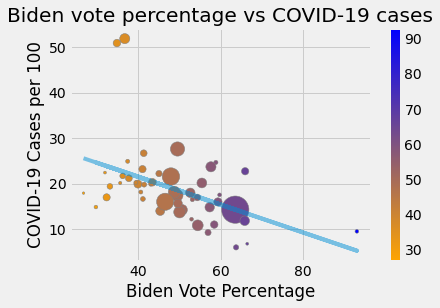

In [6]:
x=data.biden_pct
y=data.cases_per_hundred
z=data.population/50000

cm1=mcol.LinearSegmentedColormap.from_list("MyCmapName",["orange","blue"])
plt.scatter(x,y,s=z,c=x,cmap=cm1,alpha=1,edgecolors="gray",linewidth=.5)
plt.plot(x,np.poly1d(np.polyfit(x,y,1))(x),alpha=.5)

plt.xlabel("Biden Vote Percentage")
plt.ylabel("COVID-19 Cases per 100")
plt.title("Biden vote percentage vs COVID-19 cases")

plt.colorbar()
plt.show()

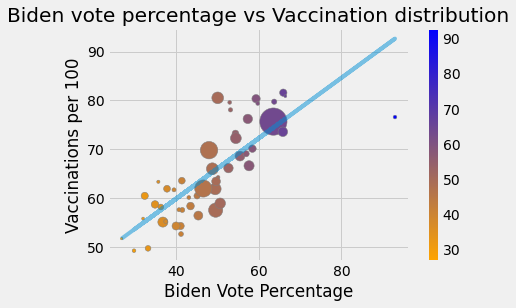

In [7]:
x=data.biden_pct
y=data.people_vaccinated_per_hundred
z=data.population/50000

cm1=mcol.LinearSegmentedColormap.from_list("MyCmapName",["orange","blue"])
plt.scatter(x,y,s=z,c=x,cmap=cm1,alpha=1,edgecolors="grey",linewidth=.5)
plt.plot(x,np.poly1d(np.polyfit(x,y,1))(x),alpha=.5)

plt.xlabel("Biden Vote Percentage")
plt.ylabel("Vaccinations per 100")
plt.title("Biden vote percentage vs Vaccination distribution")

plt.colorbar()
plt.show()

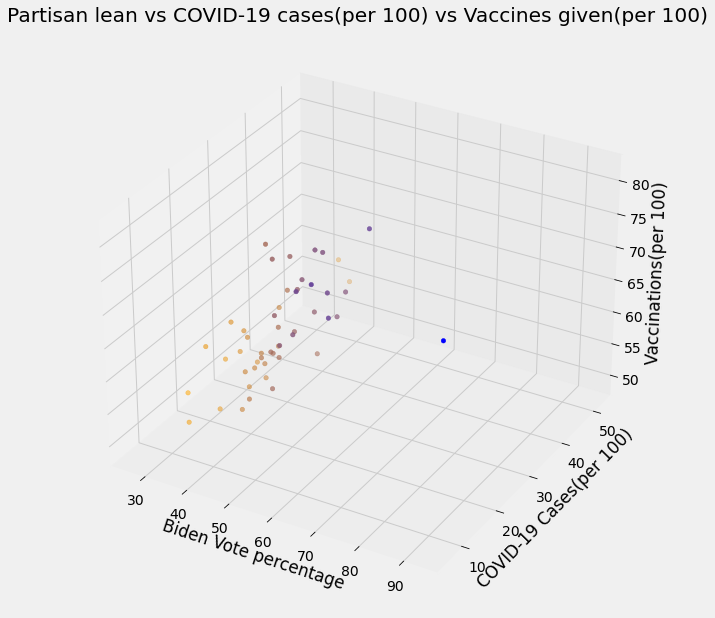

In [8]:
z=data.people_vaccinated_per_hundred
x=data.biden_pct
y=data.cases_per_hundred

fig=plt.figure(figsize=(15,10))
ax=plt.axes(projection="3d")
ax.scatter3D(x,y,z,c=x,cmap=cm1)
plt.title("Partisan lean vs COVID-19 cases(per 100) vs Vaccines given(per 100)")
xLabel=ax.set_xlabel("Biden Vote percentage",linespacing=3.5)
yLabel=ax.set_ylabel("COVID-19 Cases(per 100)",linespacing=3.5)
zLabel=ax.set_zlabel("Vaccinations(per 100)",linespacing=3.5)

plt.show()

# Prediction Analysis On the US COVID-19 Vaccination

## Visualize corrleation

Text(0.5, 1.0, 'Correlation Between different Features')

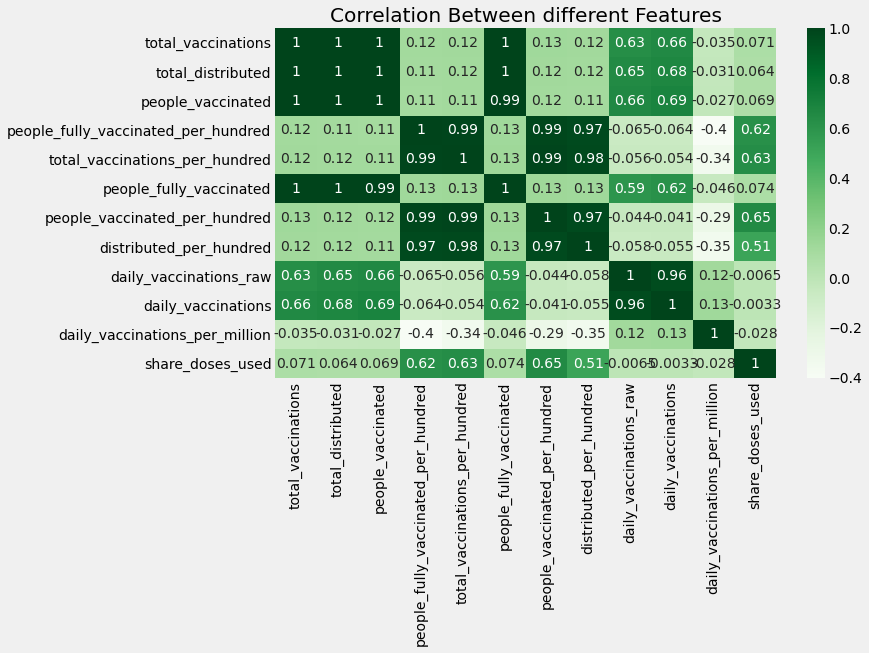

In [9]:
fig,ax=plt.subplots(figsize=(10,6))
sns.heatmap(usv.corr(),annot=True,cmap="Greens")
plt.title('Correlation Between different Features')

In [10]:
usv['date']=pd.to_datetime(usv['date'])
dt=usv.groupby('date').agg({"total_vaccinations":"sum","total_vaccinations_per_hundred":"mean","people_vaccinated_per_hundred":"mean"})

dt.dropna(subset=['total_vaccinations'])
remove_zero=dt['total_vaccinations'].isin([0])
dt=dt[~remove_zero]

Text(0, 0.5, 'Total vaccinations')

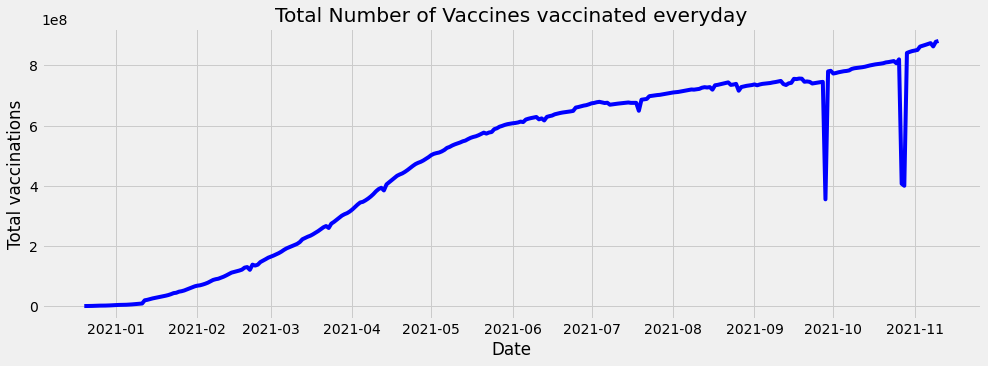

In [11]:
fig,ax=plt.subplots(figsize=(15,5))
sns.lineplot(x=dt.index,y=dt['total_vaccinations'],color='blue')
plt.title('Total Number of Vaccines vaccinated everyday')
plt.xlabel("Date")
plt.ylabel("Total vaccinations")

Text(0, 0.5, '')

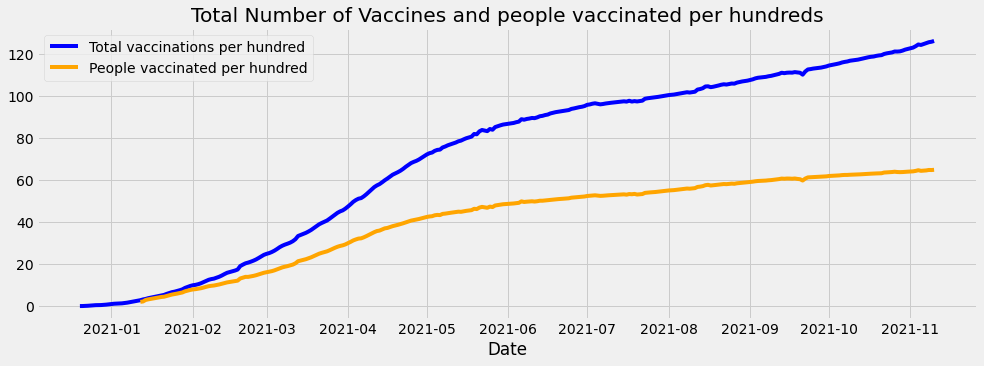

In [12]:
fig,ax=plt.subplots(figsize=(15,5))
sns.lineplot(x=dt.index,y=dt['total_vaccinations_per_hundred'],color='blue',label='Total vaccinations per hundred')
sns.lineplot(x=dt.index,y=dt['people_vaccinated_per_hundred'],color='orange',label='People vaccinated per hundred')
plt.title('Total Number of Vaccines and people vaccinated per hundreds')
plt.xlabel("Date")
plt.ylabel("")

## LinearRegression model

In [13]:
dt['date_difference']=dt['total_vaccinations']
count=0
for index, row in dt.iterrows():
    row['date_difference']=count
    count+=1

In [14]:
from sklearn.linear_model import LinearRegression
model=LinearRegression()

x=dt[['date_difference']]
y=dt['total_vaccinations']
model.fit(x,y)
pr=model.predict(x)

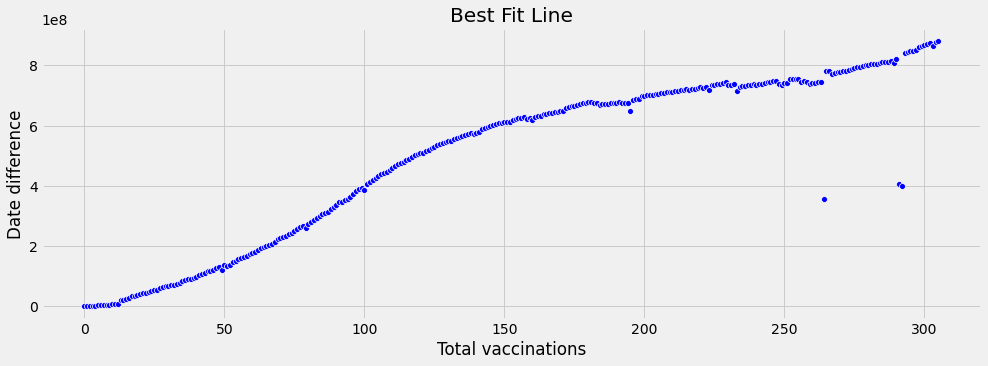

In [15]:
fig,ax=plt.subplots(figsize=(15,5))
sns.scatterplot(dt['date_difference'],dt['total_vaccinations'],color='blue')
plt.xlabel('Total vaccinations')
plt.ylabel('Date difference')
plt.title('Best Fit Line')
plt.show()

In [16]:
print(int(model.predict([[30]])))

149008859
